# Sales Prediction

In [102]:
# importing the packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from pylab import rcParams
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error

In [63]:
# reading the data

sales_data = pd.read_csv("Global+Superstore+Data.csv")
sales_data.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


In [64]:
sales_data.describe()

,Sales,Profit
count,51290.000000,51290.000000
mean,246.490581,28.610982
std,487.565361,174.340972
min,0.444000,-6599.978000
25%,30.758625,0.000000
50%,85.053000,9.240000
75%,251.053200,36.810000
max,22638.480000,8399.976000


In [65]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  51290 non-null  object 
 1   Segment     51290 non-null  object 
 2   Market      51290 non-null  object 
 3   Sales       51290 non-null  float64
 4   Profit      51290 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


In [66]:
sales_data.nunique()

Order Date     1430
Segment           3
Market            7
Sales         22995
Profit        24575
dtype: int64

In [67]:
sales_data["Order Date"].min()

'01-01-2011'

In [68]:
sales_data["Order Date"].max()

'31-12-2014'

We have data between 2011 to 2014.

In [69]:
# check for any null values
sales_data.isnull().sum()

Order Date    0
Segment       0
Market        0
Sales         0
Profit        0
dtype: int64

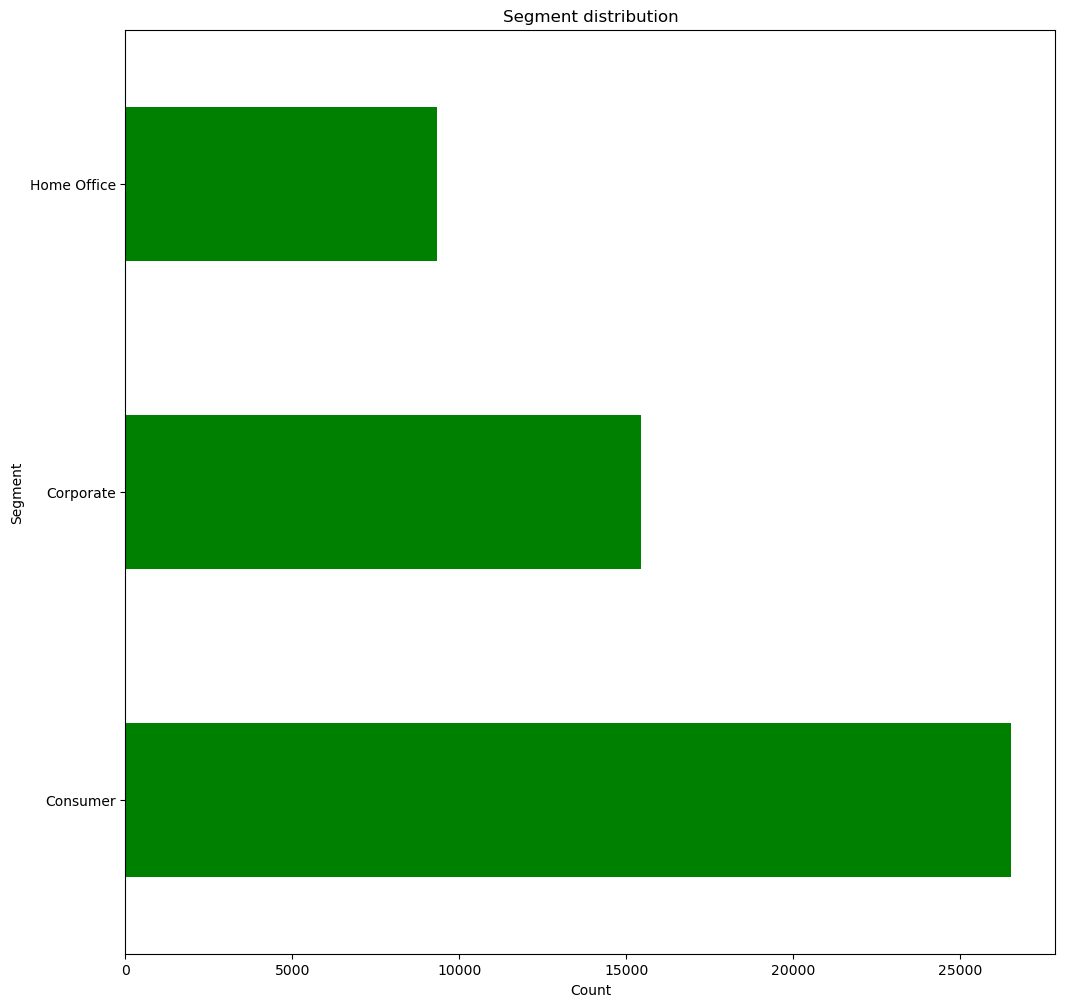

In [70]:
# checking the distribution of the Segment data

sales_data["Segment"].value_counts().plot(kind = 'barh', color = 'green')
plt.ylabel('Segment')
plt.xlabel('Count')
plt.title('Segment distribution')
plt.show()

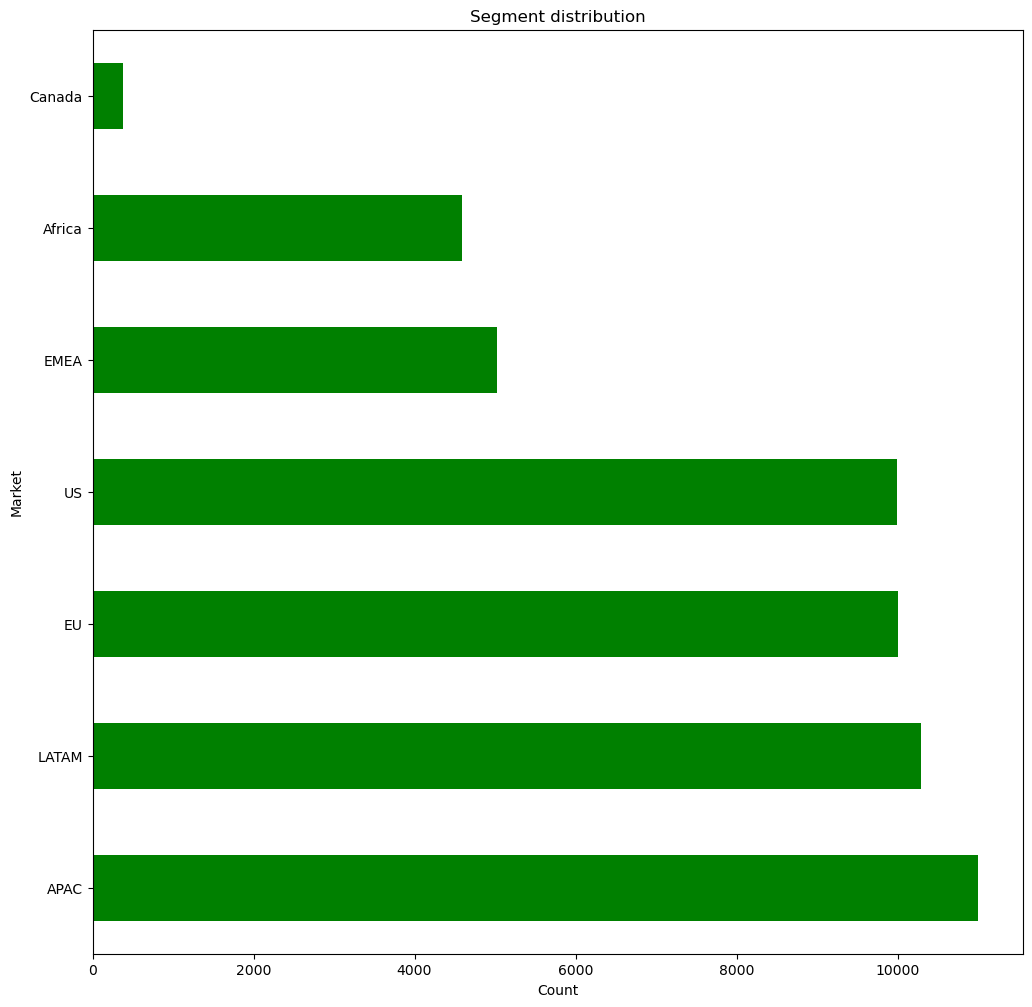

In [71]:
# checking the distribution of the market data

sales_data["Market"].value_counts().plot(kind = 'barh', color = 'green')
plt.ylabel('Market')
plt.xlabel('Count')
plt.title('Segment distribution')
plt.show()

## Data Preparation

In [72]:
# combining segments and market

sales_data["Market_segment"] = sales_data["Market"] + "-" +sales_data["Segment"]
sales_data.head()

,Order Date,Segment,Market,Sales,Profit,Market_segment
0,31-07-2012,Consumer,US,2309.650,762.1845,US-Consumer
1,05-02-2013,Corporate,APAC,3709.395,-288.7650,APAC-Corporate
2,17-10-2013,Consumer,APAC,5175.171,919.9710,APAC-Consumer
3,28-01-2013,Home Office,EU,2892.510,-96.5400,EU-Home Office
4,05-11-2013,Consumer,Africa,2832.960,311.5200,Africa-Consumer


In [73]:
sales_data.drop(["Segment","Market"], axis = 1,inplace = True)
sales_data.head()

,Order Date,Sales,Profit,Market_segment
0,31-07-2012,2309.650,762.1845,US-Consumer
1,05-02-2013,3709.395,-288.7650,APAC-Corporate
2,17-10-2013,5175.171,919.9710,APAC-Consumer
3,28-01-2013,2892.510,-96.5400,EU-Home Office
4,05-11-2013,2832.960,311.5200,Africa-Consumer


In [74]:
sales_data.shape

(51290, 4)

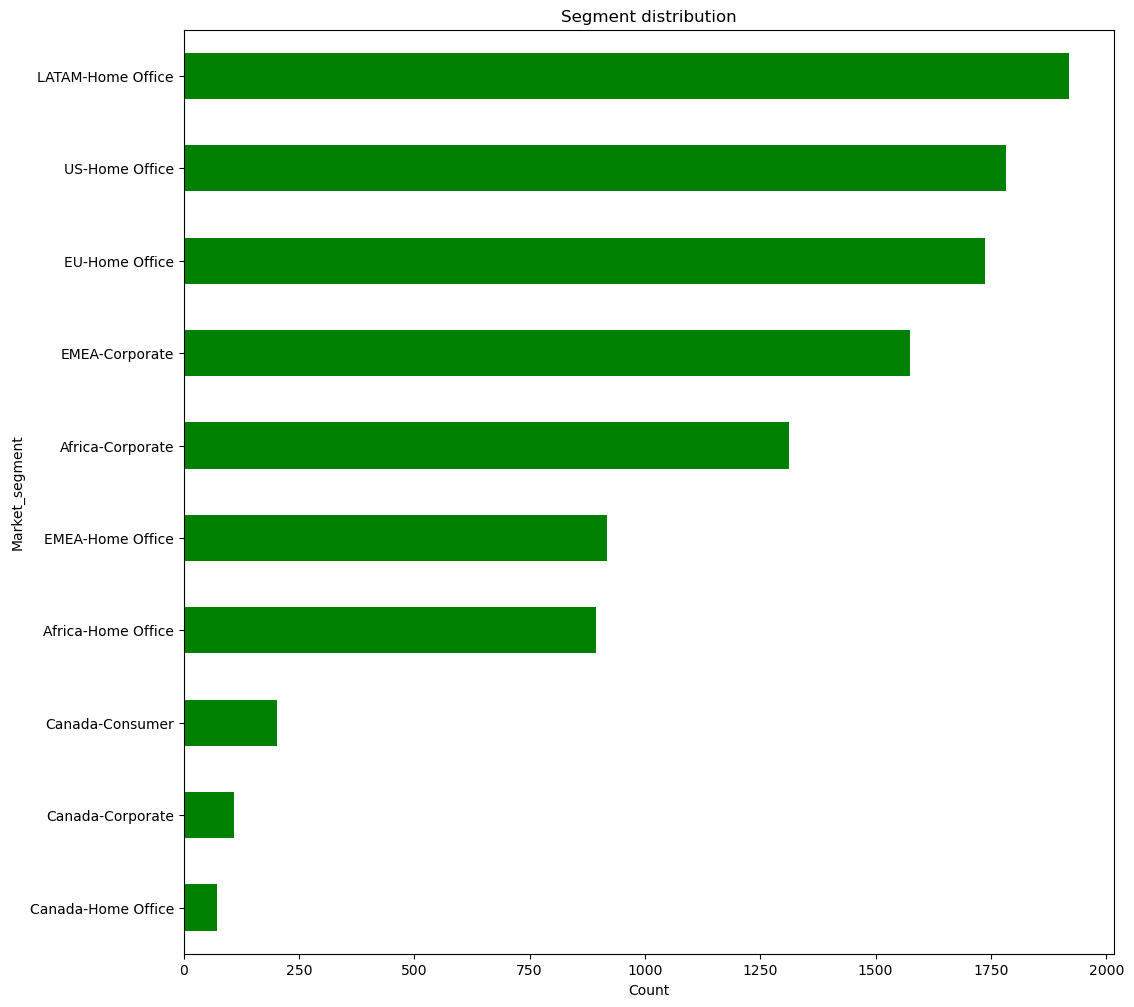

In [75]:
# checking the top 10 of the segment-market data

sales_data["Market_segment"].value_counts().sort_values(ascending=1)[:10].plot(kind = 'barh', color = 'green')
plt.ylabel('Market_segment')
plt.xlabel('Count')
plt.title('Segment distribution')
plt.show()

In [76]:
# change the order date into date time format

# apply function to date column
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date']).dt.to_period('m')
sales_data = sales_data.set_index("Order Date")
sales_data.head()

,Sales,Profit,Market_segment
Order Date,,,
2012-07,2309.650,762.1845,US-Consumer
2013-05,3709.395,-288.7650,APAC-Corporate
2013-10,5175.171,919.9710,APAC-Consumer
2013-01,2892.510,-96.5400,EU-Home Office
2013-05,2832.960,311.5200,Africa-Consumer


In [77]:
sales_data.sort_values(by = "Order Date")

,Sales,Profit,Market_segment
Order Date,,,
2011-01,139.6500,15.3000,EU-Corporate
2011-01,88.4400,15.8400,EU-Consumer
2011-01,11.4300,4.1100,EU-Corporate
2011-01,491.0000,122.7000,LATAM-Consumer
2011-01,4.7100,0.0000,US-Home Office
...,...,...,...
2014-12,42.9600,5.0400,EMEA-Corporate
2014-12,80.7360,-117.1440,EMEA-Consumer
2014-12,608.5800,0.0000,APAC-Consumer


In [78]:
new_sales_data = sales_data.pivot_table(index='Order Date', values = 'Profit', columns = 'Market_segment', aggfunc = 'sum')

In [79]:
new_sales_data.head()

Market_segment,APAC-Consumer,APAC-Corporate,APAC-Home Office,Africa-Consumer,Africa-Corporate,Africa-Home Office,Canada-Consumer,Canada-Corporate,Canada-Home Office,EMEA-Consumer,...,EMEA-Home Office,EU-Consumer,EU-Corporate,EU-Home Office,LATAM-Consumer,LATAM-Corporate,LATAM-Home Office,US-Consumer,US-Corporate,US-Home Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


## Spliting data into test-train dataset

In [80]:
train_length = 42
profit_train = new_sales_data[:train_length]

profit_test = new_sales_data[train_length:]

## calculating the CoV

In [81]:
mean=np.mean(profit_train)
std= np.std(profit_train)

CoV= pd.DataFrame(mean)
CoV['std']= std
CoV['CoV'] = std/mean
CoV= CoV.reset_index()
CoV.columns= ['Market_Segment', 'Mean', 'Std', 'CoV']
CoV.sort_values(by='CoV', ascending= True, inplace = True)

In [82]:
CoV

,Market_Segment,Mean,Std,CoV
0,APAC-Consumer,4400.894243,2300.457687,0.522725
1,APAC-Corporate,2574.919807,1364.837734,0.530051
12,EU-Consumer,3699.977143,2202.282289,0.595215
15,LATAM-Consumer,2295.555697,1569.632686,0.683770
13,EU-Corporate,2216.299429,1600.336696,0.722076
16,LATAM-Corporate,1122.633016,990.360880,0.882177
14,EU-Home Office,1224.456536,1148.627937,0.938072
2,APAC-Home Office,1511.088314,1523.508658,1.008219
18,US-Consumer,2686.740912,2715.031412,1.010530
19,US-Corporate,1754.199083,1880.200775,1.071829


We want to target most reliable and profit making market segment. We would move ahead with APAC-Consumer that has least CoV.

## Selecting the targeted data

In [86]:
# selecting the targeted data

final_data = sales_data[sales_data.Market_segment == 'APAC-Consumer']

In [87]:
final_data.head()

,Sales,Profit,Market_segment
Order Date,,,
2013-10,5175.171,919.971,APAC-Consumer
2011-07,1822.080,564.840,APAC-Consumer
2012-04,5244.840,996.480,APAC-Consumer
2013-06,3701.520,1036.080,APAC-Consumer
2012-02,1878.720,582.360,APAC-Consumer


In [88]:
sales_data_agg = pd.DataFrame(final_data[["Sales"]].groupby('Order Date')['Sales'].sum())
sales_data_agg.head()

,Sales
Order Date,
2011-01,18821.9898
2011-02,23313.3531
2011-03,26518.4919
2011-04,12046.0923
2011-05,25941.9000


In [89]:
sales_data_agg.shape

(48, 1)

## Sales Time series representation

Text(0.5, 1.0, 'Sales')

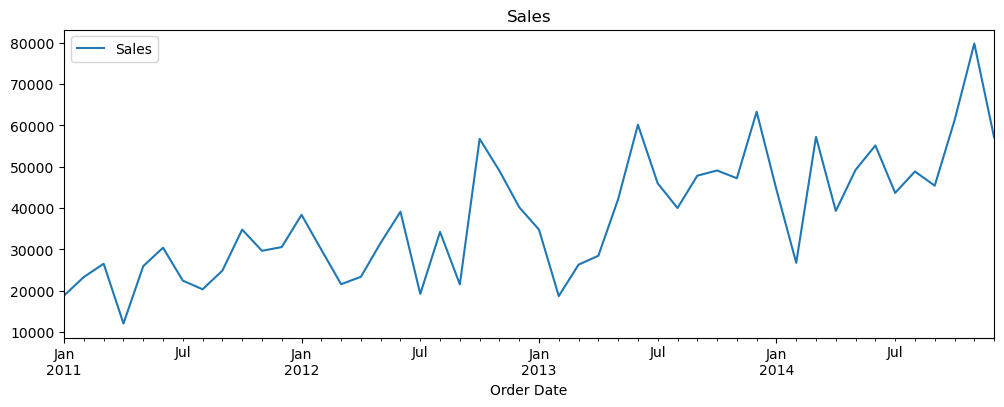

In [90]:
sales_data_agg.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Sales')

## Split the sales data into train and test

In [91]:
sales_data_agg.interpolate(inplace = True)
sales_data_agg.index=sales_data_agg.index.to_timestamp()

In [92]:
sales_train = sales_data_agg[:train_length]
sales_test = sales_data_agg[train_length:]

## Time series Decomposition

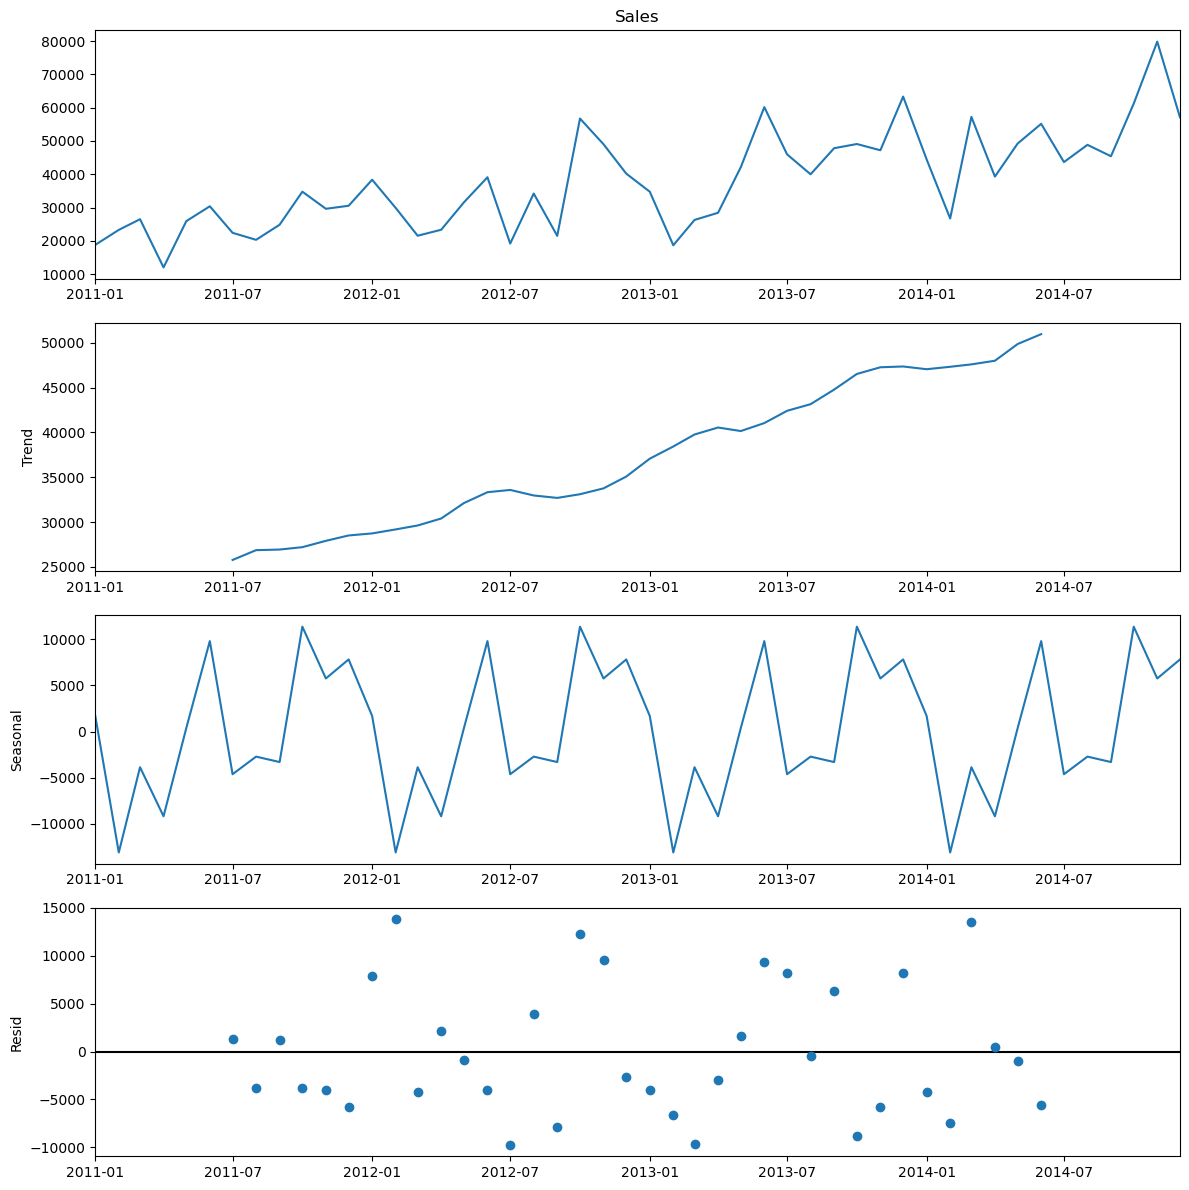

In [94]:
rcParams['figure.figsize'] = 12, 12
decomposition = sm.tsa.seasonal_decompose(sales_data_agg['Sales'], model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

## Multiplicative seasonal decomposition


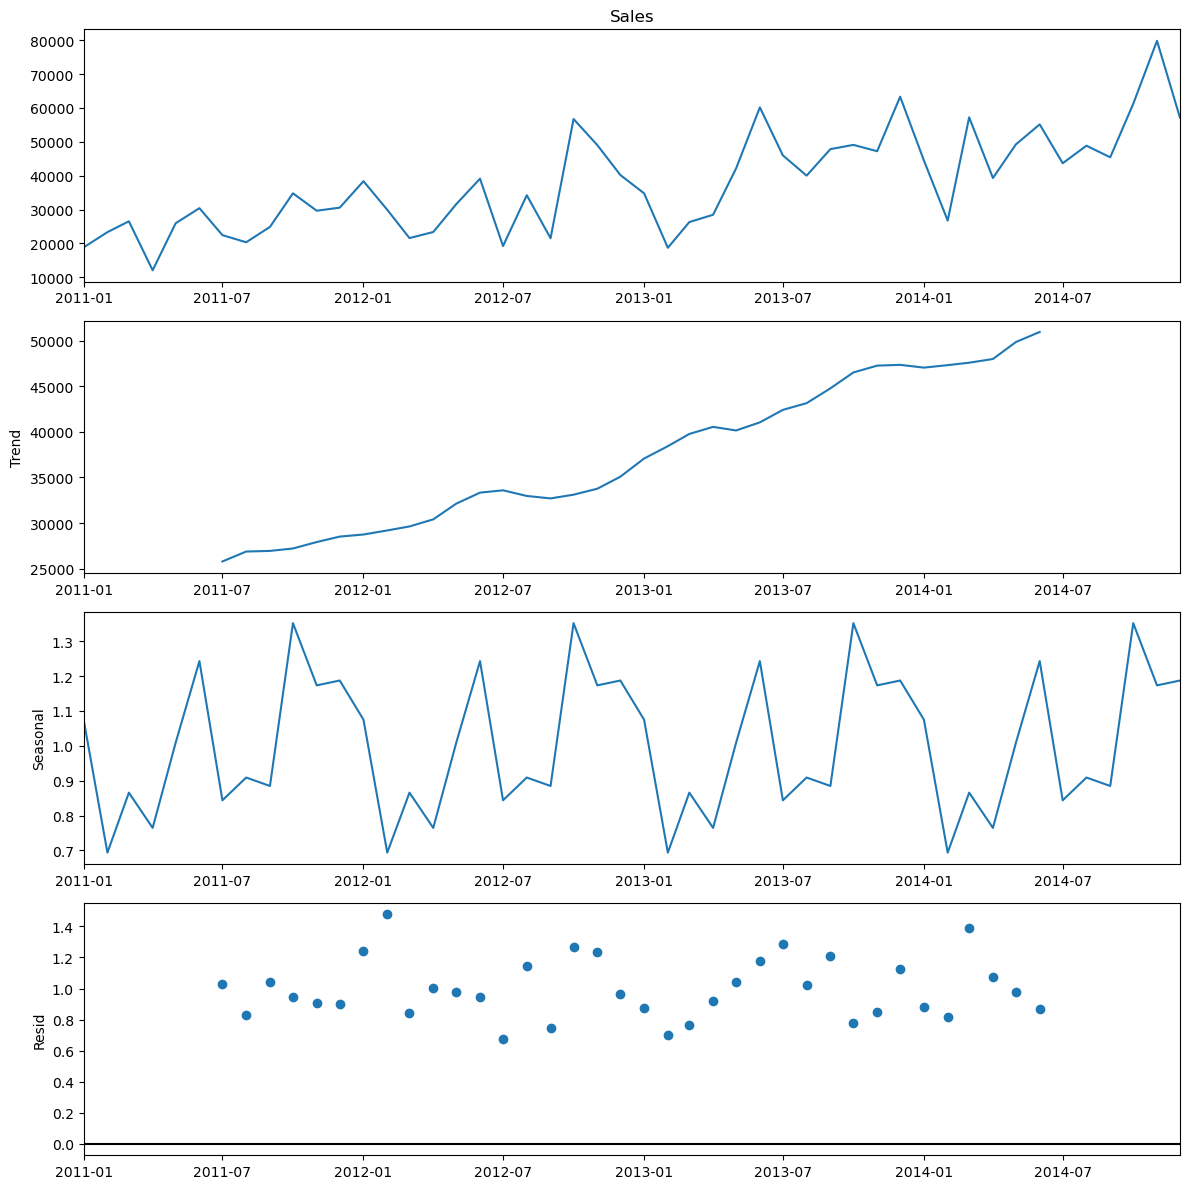

In [95]:
rcParams['figure.figsize'] = 12, 12
decomposition = sm.tsa.seasonal_decompose(sales_data_agg['Sales'], model='multiplicative') # additive seasonal index
fig = decomposition.plot()
plt.show()

As we can see from both the decompostions, there is general upward trend in the sales data. The cycle repeates every year from January to December.

## Build and evaluate time series forecast

With an upward trend in the data and seasonality we would explore Holt Winters' exponential smoothing technique methods and SARIMA model.

### Holt-Winters' Exponential Smoothing Technique - Additive

In [111]:
y_hat_hwa = sales_test.copy()
model = ExponentialSmoothing(np.asarray(sales_train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
#print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(6)

Ploting train,test, and forecast

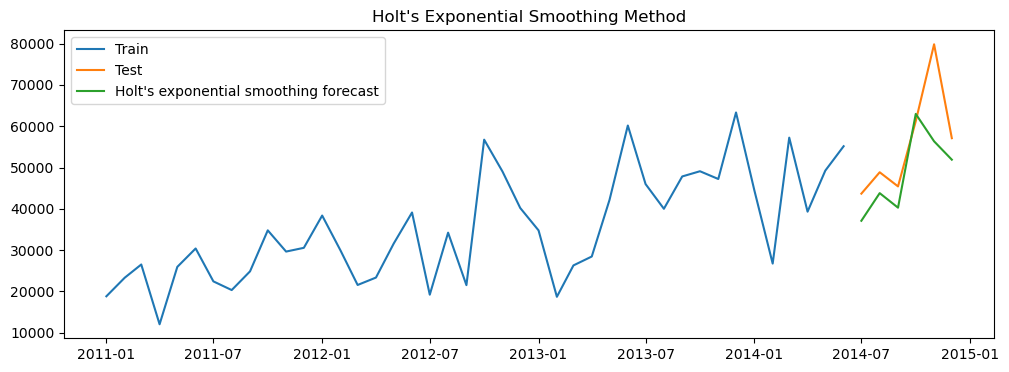

In [112]:
plt.figure(figsize=(12,4))
plt.plot( sales_train['Sales'], label='Train')
plt.plot(sales_test['Sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [118]:
rmse = np.sqrt(mean_squared_error(sales_test['Sales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(sales_test['Sales']-y_hat_hwa['hw_forecast'])/sales_test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Holt Winters\' additive method'], 'RMSE': [rmse],'MAPE': [mape] })
#results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Holt Winters' additive method,10624.26,13.02


The above graph is able predict the trend and seasonality. Let's check other models to find more accurate method.

### Holt-Winters' Exponential Smoothing Technique - Multiplicative

In [119]:
y_hat_hwm = sales_test.copy()
model = ExponentialSmoothing(np.asarray(sales_train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
#print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)

Ploting train,test, and forecast

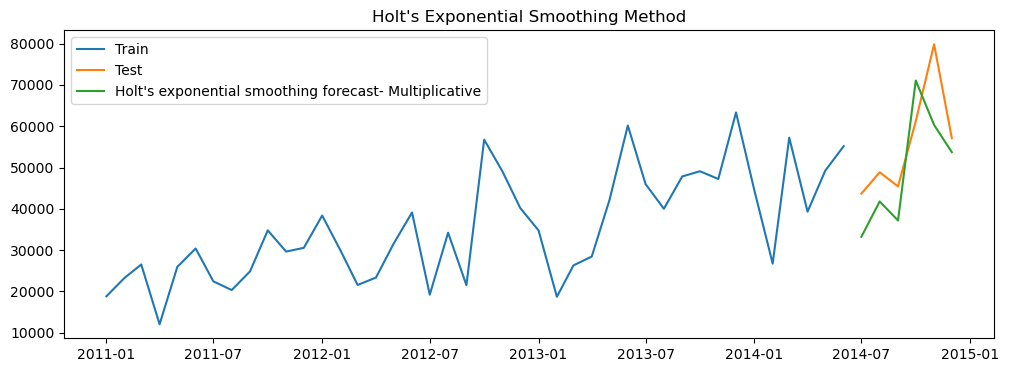

In [120]:
plt.figure(figsize=(12,4))
plt.plot( sales_train['Sales'], label='Train')
plt.plot(sales_test['Sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='Holt\'s exponential smoothing forecast- Multiplicative')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()

### Calculate RMSE and MAPE

In [121]:
rmse = np.sqrt(mean_squared_error(sales_test['Sales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(sales_test['Sales']-y_hat_hwm['hw_forecast'])/sales_test['Sales'])*100,2)

temp_results = pd.DataFrame({'Method':['Holt Winters\' multiplicative method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, temp_results])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Holt Winters' additive method,10624.26,13.02
0,Holt Winters' multiplicative method,10931.27,17.17


Multiplicative model worse than the additive model. Lets try SARIMA model on the data. But before that we would need to check whether the time series is stationary.

### Stationarity

Checking stationarity based on Augmented Dicky-Fuller Test (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test.

1. ADF TEST

ADF test uses hypothesis testing to determine the stationarity of data. Hypothesis are defined as below:

* Null Hypothesis: Time series is non-stationary i.e., dependent on time.
* Alternate Hypothesis: Time series is stationary i.e., independent of time.

We decide the results based on p-values.

* p > 0.05: null, so data is non-stationary
* p <= 0.05: Reject null, so data is stationary.

In [50]:
result = adfuller(sales_data_agg)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.376024
p-value: 0.011804


As p-value <0.05, we will reject the null hypothesis. Our data is time dependent as we can see through the graph as well. ADF concludes our data to be non-stationary.

2. KPSS Test

Here, Null Hypothesis and Alternate Hypothesis are in reverse order with Null Hypothesis focusing on trend stationarity. Since our data exhibits trend, we will check with this test as well.

In [53]:
result = kpss(sales_data_agg)

print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

KPSS Statistic: 1.103752
p-value: 0.010000


As p-value <0.05, we will reject the null hypothesis. Our data is time dependent as we can see through the graph as well. KPSS concludes our data to be non-stationary.

### Let's convert the non-stationary time series into stationary time series. 

### Box cox transformation to make variance constant

In [134]:
from scipy.stats import boxcox
data_boxcox = pd.DataFrame(boxcox(sales_data_agg['Sales'], lmbda=0))

In [135]:
data_boxcox.head()

,Sales
Order Date,
2011-01-01,9.842781
2011-02-01,10.056782
2011-03-01,10.185598
2011-04-01,9.396496
2011-05-01,10.163615


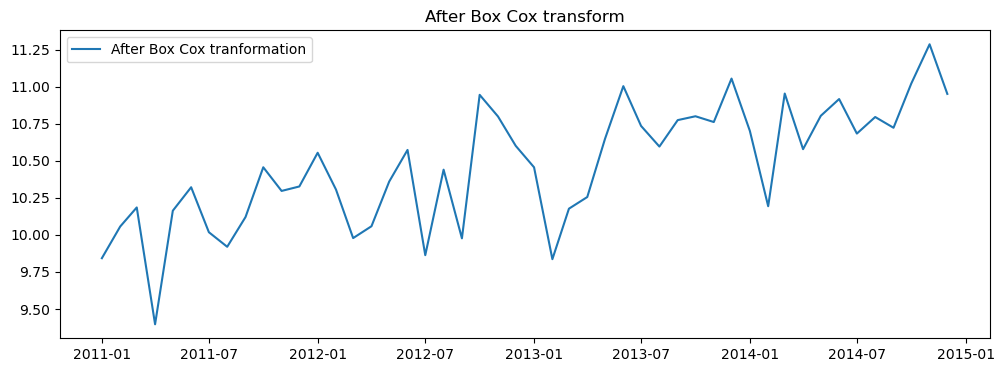

In [136]:
plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

## Differencing to remove the trend

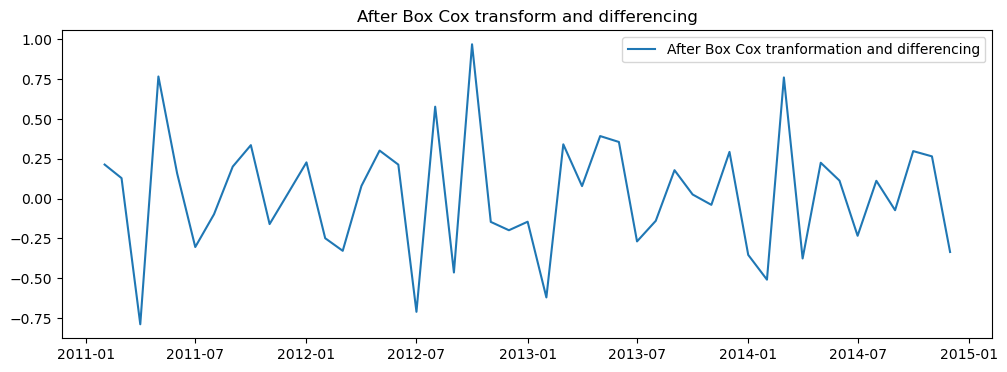

In [137]:
data_boxcox_diff = pd.DataFrame(data_boxcox - data_boxcox.shift())
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

For this problem we will be using p=1, d=1, and q = 1, as the forecasts are relatively better for these values.

### Seasonal auto regressive integrated moving average (SARIMA)

In [145]:
train_data_boxcox = data_boxcox[:train_length]
test_data_boxcox = data_boxcox[train_length:]
train_data_boxcox_diff = data_boxcox_diff[:train_length-1]
test_data_boxcox_diff = data_boxcox_diff[train_length-1:]

In [150]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit(method='cg')
print(model_fit.params)

         Current function value: 0.190340
         Iterations: 50
         Function evaluations: 120
         Gradient evaluations: 120
ar.L1       0.041659
ma.L1      -0.707103
ar.S.L12   -0.100210
ma.S.L12   -0.704915
sigma2      0.003232
dtype: float64


### Recover original time series forecast

In [151]:
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot train, test and forecast

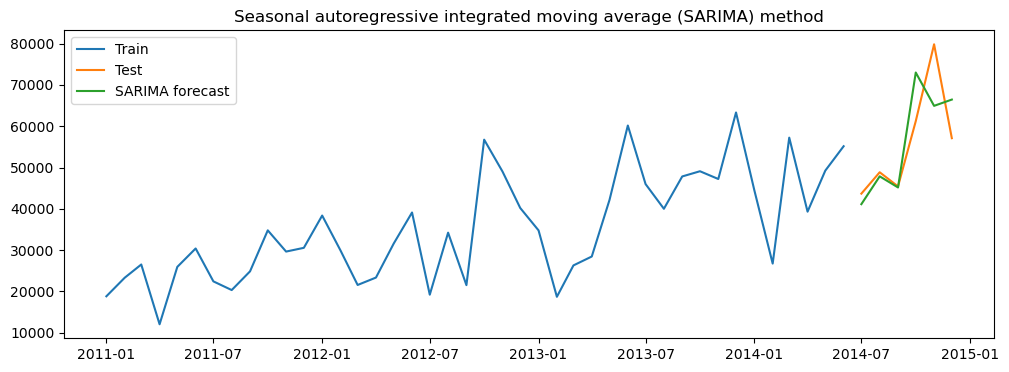

In [152]:
plt.figure(figsize=(12,4))
plt.plot(sales_train['Sales'], label='Train')
plt.plot(sales_test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][sales_test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

##### The forecast captured both trend and seasonality

### Calculate RMSE and MAPE

In [153]:
rmse = np.sqrt(mean_squared_error(sales_test['Sales'], y_hat_sarima['sarima_forecast'][sales_test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(sales_test['Sales']-y_hat_sarima['sarima_forecast'][sales_test.index.min():])/sales_test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Holt Winters' additive method,10624.26,13.02
0,Holt Winters' multiplicative method,10931.27,17.17
0,Seasonal autoregressive integrated moving aver...,8715.57,10.45


Among all the methods done above, we can conclude that forecast done using SARIMA method is able to predict the sales closer to the actual values